In [1]:
from pyfilterbank import gammatone
from matplotlib import pyplot as plt
import signal

b,a = gammatone.design_filter(
    sample_rate=44100,
    order=32,
    centerfrequency=1000.0,
    band_width=None,
    band_width_factor=1.0,
    attenuation_half_bandwidth_db=-3,
)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))
from tools import plot, utils
from tools.nn_modules import *
import numpy as np

import IPython.display as ipd

2.1.0+cpu


In [3]:
# helper functions

def plot_time_and_spec(signals, samplerate, labels):
    
    freq_axes = []
    spec_axes = []
    for signal in signals:
        h, f = utils.get_spectrum(signal, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.timeseries(
        signals, samplerate=samplerate, title="Input-output signals", labels=labels
    )
    plot.magspec(
        freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra", labels=labels
    )


def batch_2_np(batch):
    return batch[0][0].detach().numpy()


def audio_play(signal, samplerate):
    return ipd.display(ipd.Audio(signal, rate=samplerate))  # load a NumPy array

In [4]:
# define parameters
samplerate = 22050
center_frequencies = [1000]
n_batch = 1
n_samples = 22050
n_channels = 1
taps = 128

In [13]:
from scipy import signal
import numpy as np


def plot_gammabank2(bank, center_frequencies, samplerate):
    freq_axes = []
    spec_axes = []
    for filter in bank.filters:
        h,w, _ = gammatone.freqz_fos(filter.b, filter.a,32,512)
        f = w  * samplerate
        freq_axes.append(f)
        spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.magspec(
        freq_axes=freq_axes,
        spec_axes=spec_axes,
        title="Magnitude response",
        labels=center_frequencies,
    )
def plot_gammabank(bank, center_frequencies, samplerate):
    freq_axes = []
    spec_axes = []
    b, a = bank
    
    w, h = signal.freqz(b, a)
    f = w / (2*pi)  * samplerate
    freq_axes.append(f)
    spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.magspec(
        freq_axes=freq_axes,
        spec_axes=spec_axes,
        title="Magnitude response",
        labels=center_frequencies,
    )

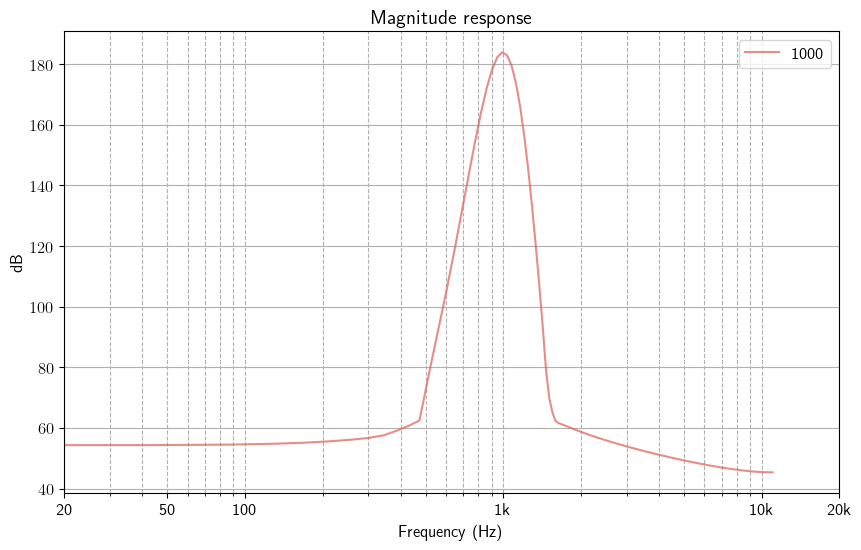

c:\Users\STNj\OneDrive - Demant\Documents\DTU\DDSP\tools\utils.py:138: RuntimeWarning: divide by zero encountered in log10
  return 20 * log10(abs(complex_spectrum))


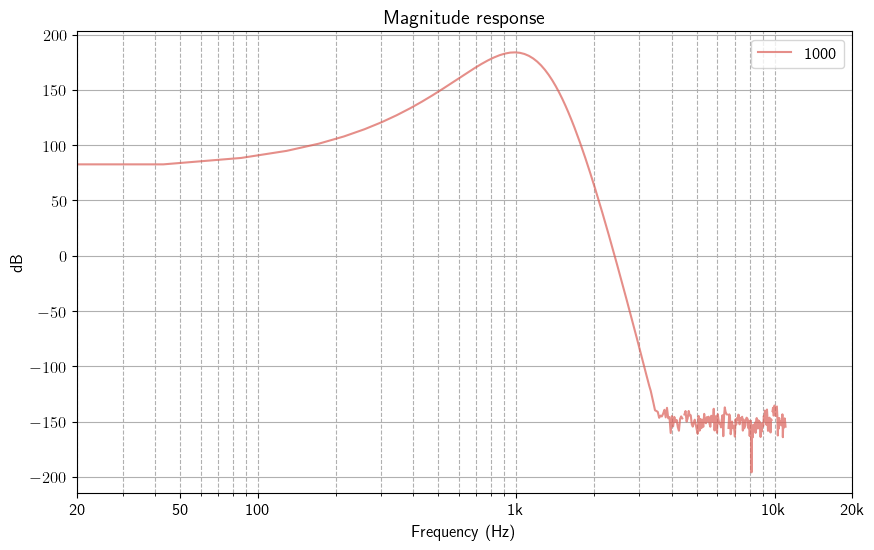

In [6]:
# initiate a normal hearing gammatone filterbank
filterbank_NH = GammaToneIIRFilterbank(
    center_frequencies=center_frequencies, samplerate=samplerate, band_width_factor=1.0
)

# initiate a impaired gammatone filterbank
filterbank_HI = GammaToneIIRFilterbank(
    center_frequencies=center_frequencies, samplerate=samplerate, band_width_factor=2.0
)

plot_gammabank(filterbank_NH, center_frequencies,samplerate)
plot_gammabank(filterbank_HI, center_frequencies,samplerate)


In [7]:
model = MyModel_v2(
    num_taps=3200,
    samplerate=samplerate,
    center_frequencies=center_frequencies,
    band_width_factor=5
)

In [8]:
import torchaudio

audio, samplerate = torchaudio.load(r"..\audio\examples\Human_voice\1.wav")
batch_size = 1
n_channels, n_samples = audio.shape
audio = audio.reshape((batch_size,n_channels,n_samples))

x, y = model(audio)

audio_play(batch_2_np(x),samplerate=samplerate)
audio_play(batch_2_np(y),samplerate=samplerate)


tensor([[[nan, nan, nan,  ..., nan, nan, nan]]])
tensor([[[nan, nan, nan,  ..., nan, nan, nan]]])


c:\Users\STNj\.conda\envs\ddsp\lib\site-packages\IPython\lib\display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
c:\Users\STNj\.conda\envs\ddsp\lib\site-packages\IPython\lib\display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


In [9]:
filterbank_NH = GammaToneIIRFilterbank(
    center_frequencies=center_frequencies, samplerate=samplerate, band_width_factor=1.0
)
a = filterbank_NH.filters[0].a

torch.imag(a).dtype
# torch.imag(a).dtype

torch.float32

tensor([[[nan, nan, nan,  ..., nan, nan, nan]]])
tensor([[[nan, nan, nan,  ..., nan, nan, nan]]])
input audio


normal hearing  output


impaired output


C:\Users\STNj\AppData\Local\Temp\ipykernel_26664\1550018179.py:22: RuntimeWarning: invalid value encountered in divide
  batch_2_np(out_NH) / max(batch_2_np(out_NH)),


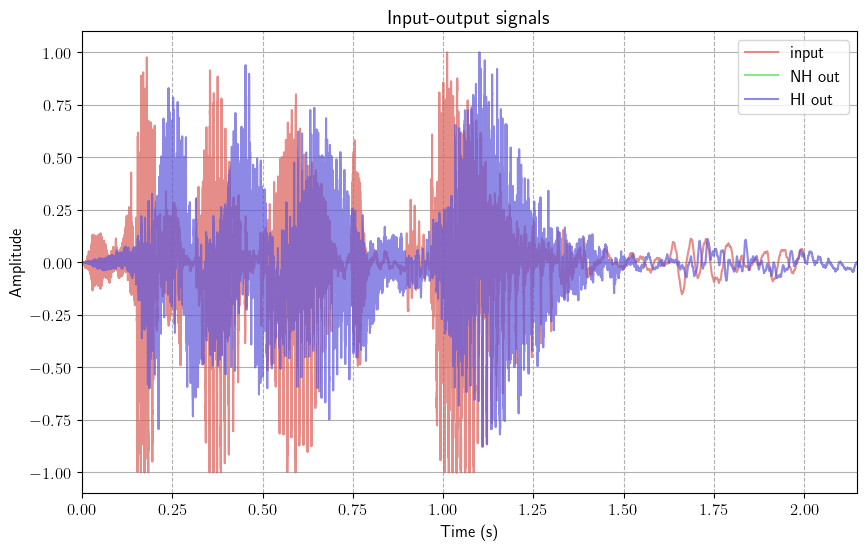

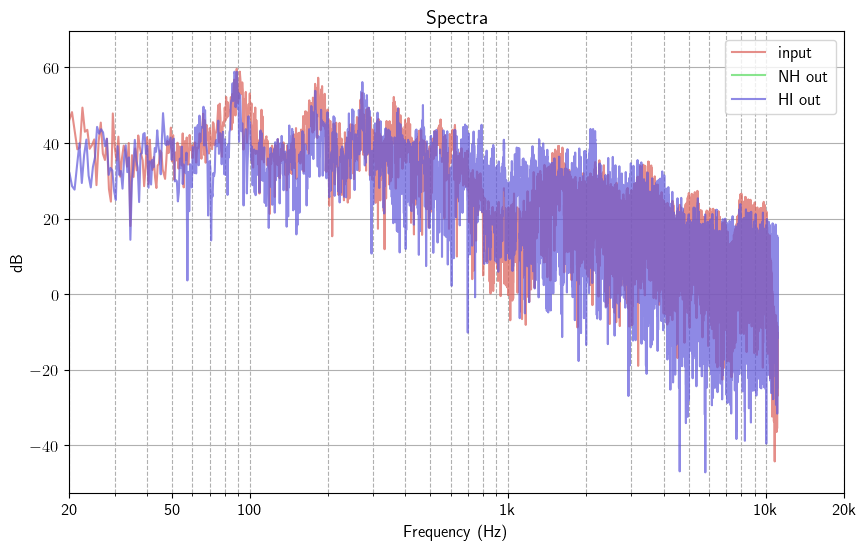

In [10]:
x_noise = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_noise[:,:,10000:] = 0.0  # Input of length 10, all zeros
x_d = torch.zeros(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_d[:, :, 0:1000] = 1.0  # Impulse

# choose which signal to excite with
x = audio

# out_NH, out_HI = model(xnoise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)


signals = [
    batch_2_np(x) / max(batch_2_np(x)),
    batch_2_np(out_NH) / max(batch_2_np(out_NH)),
    batch_2_np(out_HI) / max(batch_2_np(out_HI)),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])

In [11]:
gt = my_gammatone(center_frequencies[0],samplerate=samplerate,ftype='fir')
gt

(array([ 0.00000000e+00,  6.77241832e-07,  4.57373527e-06,  1.15784751e-05,
         1.68096112e-05,  1.10038450e-05, -1.74096378e-05, -7.90133772e-05,
        -1.79615426e-04, -3.16829729e-04, -4.77846516e-04, -6.39032673e-04,
        -7.67700827e-04, -8.26015903e-04, -7.76627806e-04, -5.89287888e-04,
        -2.47476906e-04,  2.46019659e-04,  8.65589047e-04,  1.56210581e-03,
         2.26552564e-03,  2.89077461e-03,  3.34649500e-03,  3.54578534e-03,
         3.41773653e-03,  2.91836588e-03,  2.03951709e-03,  8.14438661e-04,
        -6.80935596e-04, -2.33153228e-03, -3.99150323e-03, -5.49683877e-03]),
 [1.0])

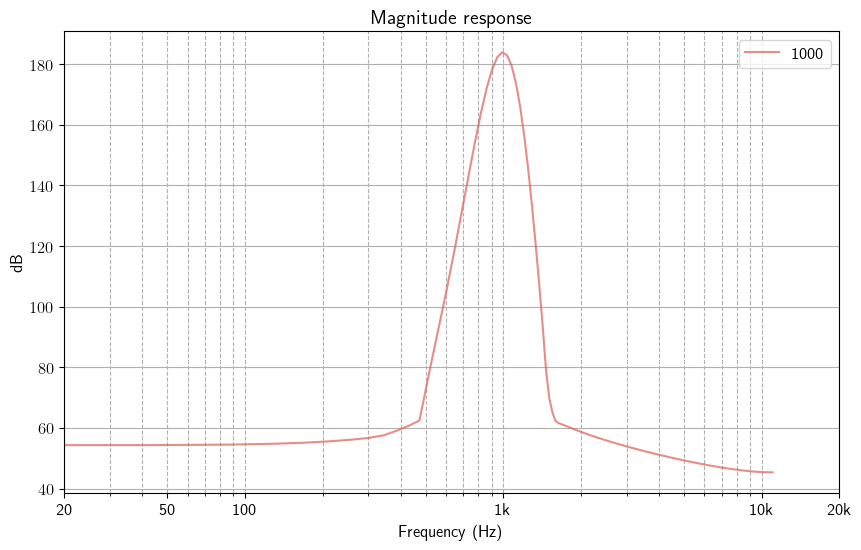

In [12]:
plot_gammabank(filterbank_NH, center_frequencies,samplerate)
